In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import mlflow
from mlflow import log_metric, log_param
from mlflow.tensorflow import autolog
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers

In [2]:
# Set the tracking URI for MLflow
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_registry_uri('sqlite:///mlflow.db')
mlflow.set_experiment('fruit-classification')

<Experiment: artifact_location='./mlruns/2', creation_time=1677318003408, experiment_id='2', last_update_time=1677318003408, lifecycle_stage='active', name='fruit-classification', tags={}>

In [4]:
# define hyperparameters
batch_size = 32
epochs = 10
learning_rate = 0.001
img_height = 256
img_width = 256


In [5]:
# set up image data generator with preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [6]:
# set up train and validation data generators
train_data_dir = '../FruitData/SyntheticData/Training_Data'
test_data_dir = '../FruitData/SyntheticData/Test_Data'

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4686 images belonging to 12 classes.
Found 1167 images belonging to 12 classes.
Found 1968 images belonging to 12 classes.


In [6]:
# Define CNN model with L2 regularization
# Define CNN model
def create_model(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0,2),
        layers.Conv2D(256, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0,2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model




In [7]:
# Create and compile model
input_shape = (img_height, img_width, 3)
num_classes = 12

model = create_model(input_shape, num_classes)

optimizer = tf.keras.optimizers.Adam()
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [8]:
# Log hyperparameters with MLflow
checkpoint_callback = ModelCheckpoint(filepath="best_model.h5",
                                       monitor="val_loss",
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode="min",
                                       verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5)
   
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

# Train the model and log the accuracy and loss for each epoch
for epoch in range(epochs):
    with mlflow.start_run():
        
        history = model.fit(train_generator, epochs=1, validation_data=test_generator, callbacks=[early_stop, checkpoint_callback])
        
        # Log the metrics for the current epoch
        training_loss.append(history.history['loss'][0])
        validation_loss.append(history.history['val_loss'][0])
        training_accuracy.append(history.history['accuracy'][0])
        validation_accuracy.append(history.history['val_accuracy'][0])
        
        mlflow.log_metric("train_loss", history.history['loss'][0], step=epoch)
        mlflow.log_metric("train_accuracy", history.history['accuracy'][0], step=epoch)
        mlflow.log_metric("val_loss", history.history['val_loss'][0], step=epoch)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][0], step=epoch)
        
        #Log param
        mlflow.log_param('optimizer', optimizer.__class__.__name__)
        mlflow.log_param('learning_rate', optimizer.learning_rate.numpy())
        mlflow.log_param('batch_size', batch_size)
        # Log the TensorFlow model
        mlflow.tensorflow.log_model(model, "model")



147/147 [==============================] - ETA: 0s - loss: 0.6257 - accuracy: 0.7565
Epoch 1: val_loss improved from inf to 0.04509, saving model to best_model.h5
147/147 [==============================] - 208s 1s/step - loss: 0.6257 - accuracy: 0.7565 - val_loss: 0.0451 - val_accuracy: 0.9878


2023/02/25 18:30:59 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmp11wjvip3\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmp11wjvip3\model\data\model\assets


147/147 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9904
Epoch 1: val_loss did not improve from 0.04509
147/147 [==============================] - 203s 1s/step - loss: 0.0266 - accuracy: 0.9904 - val_loss: 0.0692 - val_accuracy: 0.9675


2023/02/25 18:34:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmpcyor93ca\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmpcyor93ca\model\data\model\assets


147/147 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.9571
Epoch 1: val_loss did not improve from 0.04509
147/147 [==============================] - 211s 1s/step - loss: 0.1490 - accuracy: 0.9571 - val_loss: 0.4932 - val_accuracy: 0.8780


2023/02/25 18:38:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmpb91snov4\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmpb91snov4\model\data\model\assets


147/147 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9938
Epoch 1: val_loss did not improve from 0.04509
147/147 [==============================] - 202s 1s/step - loss: 0.0205 - accuracy: 0.9938 - val_loss: 0.0766 - val_accuracy: 0.9822


2023/02/25 18:41:45 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmphuu18jwh\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmphuu18jwh\model\data\model\assets


147/147 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9951
Epoch 1: val_loss did not improve from 0.04509
147/147 [==============================] - 194s 1s/step - loss: 0.0151 - accuracy: 0.9951 - val_loss: 0.0517 - val_accuracy: 0.9888


2023/02/25 18:45:08 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmpn0xxa63o\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmpn0xxa63o\model\data\model\assets


147/147 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9872
Epoch 1: val_loss did not improve from 0.04509
147/147 [==============================] - 203s 1s/step - loss: 0.0465 - accuracy: 0.9872 - val_loss: 0.0573 - val_accuracy: 0.9756


2023/02/25 18:48:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmpu2d_nwtj\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmpu2d_nwtj\model\data\model\assets


147/147 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9991
Epoch 1: val_loss improved from 0.04509 to 0.01763, saving model to best_model.h5
147/147 [==============================] - 201s 1s/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 0.0176 - val_accuracy: 0.9893


2023/02/25 18:52:10 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmpej4o4eue\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmpej4o4eue\model\data\model\assets


147/147 [==============================] - ETA: 0s - loss: 4.0445e-04 - accuracy: 0.9998
Epoch 1: val_loss did not improve from 0.01763
147/147 [==============================] - 224s 2s/step - loss: 4.0445e-04 - accuracy: 0.9998 - val_loss: 0.1328 - val_accuracy: 0.9680


2023/02/25 18:56:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmpzwu3uylb\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmpzwu3uylb\model\data\model\assets


147/147 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9934
Epoch 1: val_loss did not improve from 0.01763
147/147 [==============================] - 211s 1s/step - loss: 0.0266 - accuracy: 0.9934 - val_loss: 0.0472 - val_accuracy: 0.9787


2023/02/25 18:59:48 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmprr04sdmu\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmprr04sdmu\model\data\model\assets


147/147 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.9731
Epoch 1: val_loss did not improve from 0.01763
147/147 [==============================] - 208s 1s/step - loss: 0.1059 - accuracy: 0.9731 - val_loss: 0.1504 - val_accuracy: 0.9487


2023/02/25 19:03:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmp8s4xxbsc\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\phamt\AppData\Local\Temp\tmp8s4xxbsc\model\data\model\assets


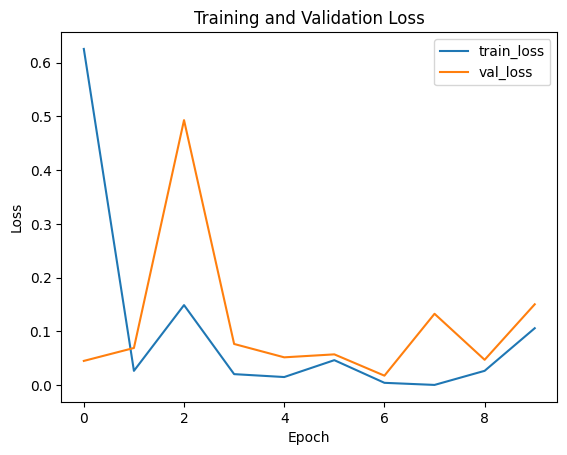

In [9]:
import matplotlib.pyplot as plt
plt.plot(training_loss, label='train_loss')
plt.plot(validation_loss, label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


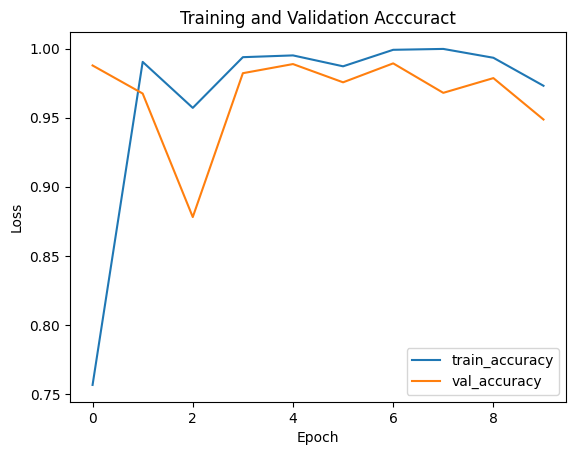

In [10]:
plt.plot(training_accuracy, label='train_accuracy')
plt.plot(validation_accuracy, label='val_accuracy')
plt.title('Training and Validation Acccuract')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#### Evaluation on thes dataset 

In [9]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
model = tf.keras.models.load_model("best_model.h5")

model.evaluate(test_generator)

62/62 [==============================] - 15s 244ms/step - loss: 0.0176 - accuracy: 0.9893


[0.017634686082601547, 0.9893292784690857]